In [1]:
import geopandas as gpd
import fiona
from shapely.geometry import Point, MultiPoint
import geoplot
import networkx as nx
from shapely.geometry import LineString
import geoplot.crs as gcrs
import os
from shapely.geometry import Point
import pandas as pd
import re
import numpy as np
from pandas_profiling import ProfileReport
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

#enable KML support
fiona.drvsupport.supported_drivers['KML'] = 'rw'

os.chdir('CO2JRC_OpenFormats/CO2Stop_Polygons Data/')

/Users/wenruizhou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [129]:
# EU country shape mask
offshore=gpd.read_file('../eu_shapes/offshore_shapes.geojson')
onshore = gpd.read_file('../eu_shapes/country_shapes.geojson')
eu = gpd.GeoDataFrame(pd.concat([onshore,offshore]),crs = 'EPSG:4326')
eu['geometry']= eu.buffer(0)

In [12]:
def load2geodf(Path = '../CO2Stop_DataInterrogationSystem/Hydrocarbon_Formations.csv'):
    f = pd.read_csv(Path)
    f['geometry'] = f.apply(lambda x: Point((x['X'],x['Y'])),axis=1)
    f = gpd.GeoDataFrame(f,crs = 'EPSG:23032')
    candidate = [] 
    for i in f.columns:
        if re.search('cap',i.lower()):
            candidate.append(i)
    candidate += list(f.columns[:6])
    candidate.append('COUNTRY')
    return f,candidate

# storage unit

In [174]:
storage_unit,su_cap = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Storage_Units.csv')
# combine estimation and input of each country
storage_unit['EST_STORECAP_MEAN'] = storage_unit.apply(lambda x: x['STORE_CAP_MEAN'] \
                                                       if x['EST_STORECAP_MEAN'] == 0 else x['EST_STORECAP_MEAN'],\
                                                      axis=1)

pattern = re.compile('|'.join(['EST_STORECAP_','STORE_CAP_','STORE_CAP_HCDAUGHTER','TOTAL_STORE_CAP']))
capacity_type = [ x for x in su_cap if re.search(pattern,x)]

storage_unit_capacity_sample = storage_unit[su_cap]
storage_unit_capacity_sample = storage_unit_capacity_sample.round(pd.Series([3]*len(capacity_type), index=capacity_type))
storage_unit_capacity_sample.to_csv('storage_unit_capacity_sample.csv',index = False)

print(storage_unit['X_DD'].unique())
#no WSG84 Coordinate was given

[0.]


In [33]:
pattern = re.compile('|'.join(['MAX','MIN','MEAN']))
capacity_type = [re.sub(pattern,'',x) for x in su_cap if re.search('cap',x.lower())]
set(capacity_type)

{'CAP_CAL_METHOD',
 'CAP_EST_METHOD',
 'EST_CAP_ENT_PRESS',
 'EST_STORECAP_',
 'STORE_CAP_',
 'STORE_CAP_HCDAUGHTER',
 'TOTAL_STORE_CAP'}

In [145]:
su_cap

['EST_STORECAP_MIN',
 'EST_STORECAP_MEAN',
 'EST_STORECAP_MAX',
 'CAP_EST_METHOD',
 'STORE_CAP_MIN',
 'STORE_CAP_MEAN',
 'STORE_CAP_MAX',
 'CAP_CAL_METHOD',
 'TOTAL_STORE_CAP',
 'STORE_CAP_HCDAUGHTER',
 'EST_CAP_ENT_PRESS',
 'OBJECTID',
 'FORMATION_ID',
 'STORAGE_UNIT_ID',
 'STORAGE_UNIT_NAME',
 'ASSESS_UNIT_TYPE',
 'PERIOD_MIN',
 'COUNTRY']

In [155]:
pattern = re.compile('|'.join(['EST_STORECAP_','STORE_CAP_','STORE_CAP_HCDAUGHTER','TOTAL_STORE_CAP']))
capacity_type = [ x for x in su_cap if re.search(pattern,x)]

In [156]:
df = storage_unit[capacity_type+['COUNTRY']].groupby('COUNTRY').sum().reset_index()

<AxesSubplot:xlabel='COUNTRY'>

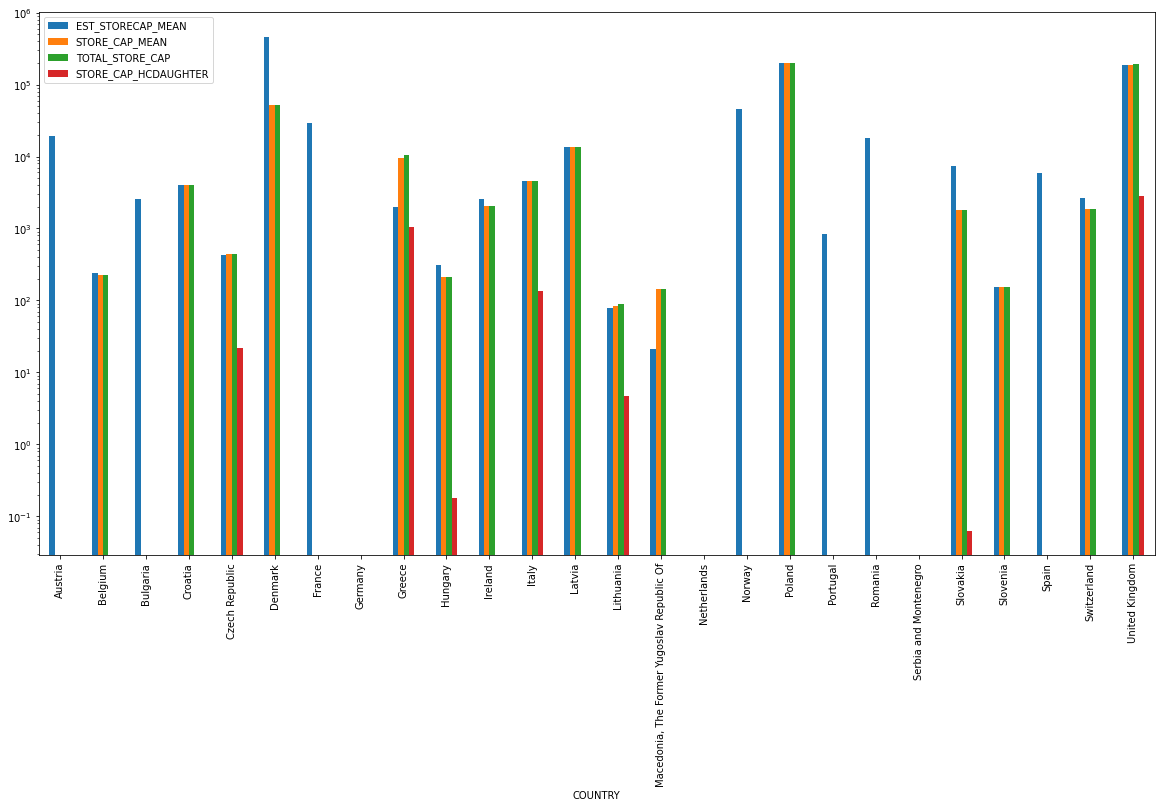

In [176]:
df.plot(x="COUNTRY", y=[x for x in capacity_type if re.search('mean|total_|daughter',x.lower())], kind="bar",figsize = (20,10),logy = True)

In [ ]:
import seaborn as sns
sns.histplot(data=tips, x="day", hue="sex", multiple="dodge", shrink=.8)

In [37]:
'STORE_CAP_DAUGHTER' in storage_unit.columns
# we only have 'STORE_CAP_HCDAUGHTER'

False

source: https://ec.europa.eu/energy/studies/assessment-co2-storage-potential-europe-co2stop_en 
https://ec.europa.eu/energy/sites/default/files/documents/56-2014%20Final%20report.pdf p43-45


* EST_STORECAP_
    - estimated CO2 storage capacity (Mt)
* STORE_CAP_
    -  calculated by using method: Connected pore volume and storage efficiency (Method 1)
* STORE_CAP_HCDAUGHTER
    - total Storage capacity of the daughter units (but according to table, it just have part of capacity of hc fields)
    
* TOTAL_STORE_CAP
    - can't find it in final report
    - but according to my check: almostly (94%) STORE_CAP_MEAN+ STORE_CAP_HCDAUGHTER = TOTAL_STORE_CAP

# trap unit(daughter unit)

In [173]:
trap1, trap_cap1 = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps.csv')
trap2, trap_cap2 = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps_Temp.csv')
trap3, trap_cap3 = load2geodf('../CO2Stop_DataInterrogationSystem/Hydrocarbon_Traps1.csv')
trap_sample = pd.concat([trap1[trap_cap1],trap2[trap_cap2],trap3[trap_cap3]])
trap_sample = trap_sample.round(3)
trap_sample.to_csv('trap_sample.csv',index=False)

In [172]:
trap_sample[trap_sample.MIN_EST_STORE_CAP_GAS!=0].MIN_EST_STORE_CAP_GAS

78       4.00
79      11.50
80       4.80
131      3.50
135      2.00
        ...  
165    163.10
166    177.06
169    110.20
187     26.40
188      6.84
Name: MIN_EST_STORE_CAP_GAS, Length: 194, dtype: float64

In [34]:
pattern = re.compile('|'.join(['MAX','MIN','MEAN']))
capacity_type = [re.sub(pattern,'',x) for x in trap_cap1 if re.search('cap',x.lower())]
set(capacity_type)

{'CAP_CAL_METHOD',
 'CAP_EST_METHOD',
 'EST_CAP_ENT_PRESS',
 'EST_STORECAP_',
 'STORE_CAP_',
 '_CALC_STORE_CAP_GAS',
 '_CALC_STORE_CAP_OIL',
 '_EST_STORE_CAP_GAS',
 '_EST_STORE_CAP_OIL'}

## four types of  capacity:
* EST_STORECAP_ (only aquifer storage)
    - min mean max
    
* STORE_CAP_ (only aquifer storage)
    - min mean max
* _CALC_STORE_CAP_ (gas and oil)
 
    - min mean max
* _EST_STORE_CAP_ (gas and oil)

    - min mean max

In [5]:
#load capacity per country table
table = pd.read_csv('Total_Storage_Cap_Aquif_HCFields.csv')
table.sort_values('COUNTRY').head()

#add alpha_2 country code
import pycountry
unnormal = ['Serbia & Montenegro']
table['alpha_2'] = table.COUNTRY.apply(lambda x: pycountry.countries.search_fuzzy(x)[0].alpha_2 if x not in unnormal else x)

<GeoAxesSubplot:>

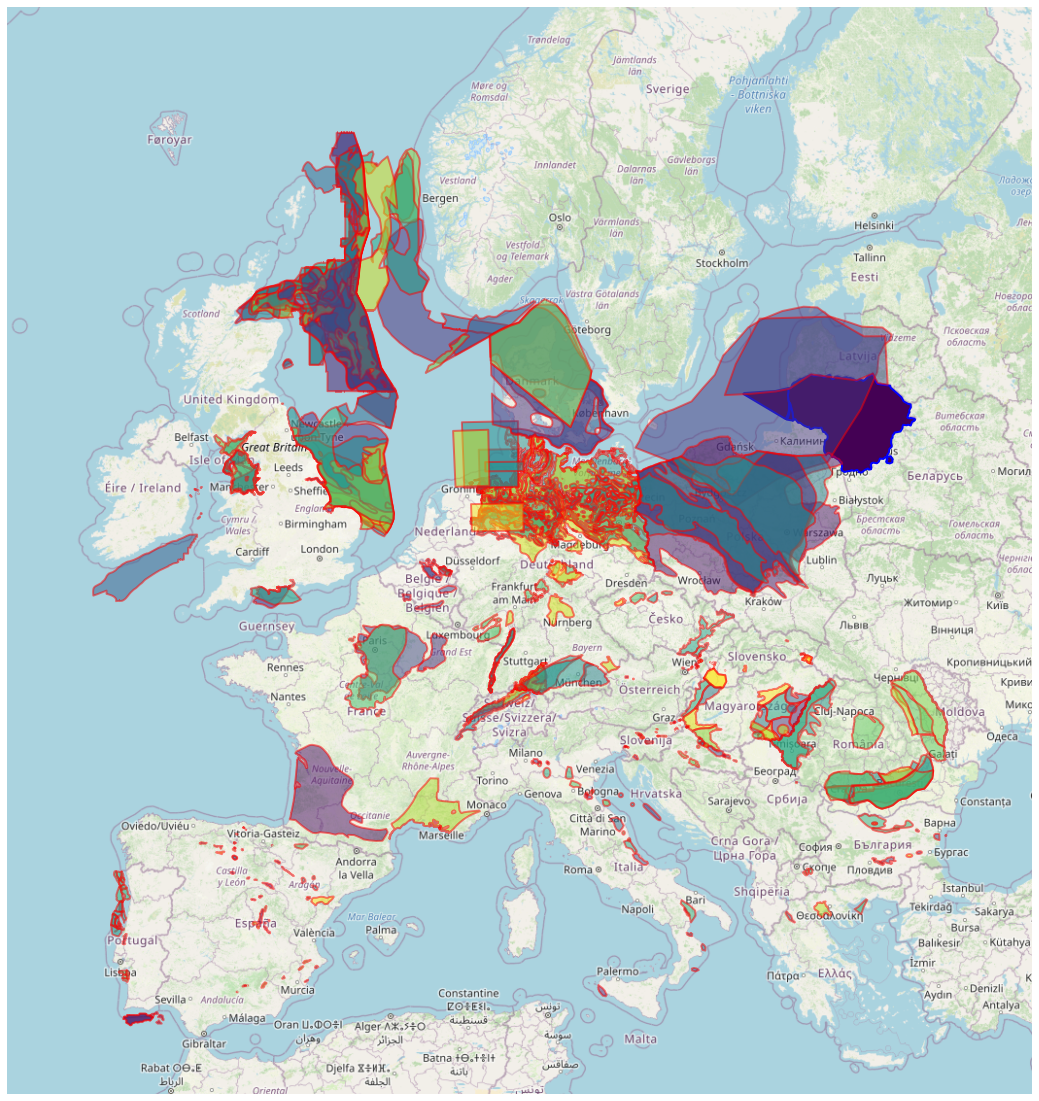

In [6]:
#StorerUnits 
Storeunit = gpd.read_file('StorageUnits_March13.kml', driver='KML')
Storeunit['geometry'] = Storeunit.buffer(0)
background=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(background,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)
geoplot.choropleth(eu[eu.name == 'LT'], hue='name',ax=ax,alpha=1,edgecolor='blue', linewidth=2)
geoplot.choropleth(Storeunit, hue='Name',ax=ax,alpha=0.5,edgecolor='red', linewidth=2)


In [7]:
from fuzzywuzzy import process, fuzz
import numpy as np
#matching algorithm
storage_unit_sample = storage_unit[['STORAGE_UNIT_NAME','EST_STORECAP_MEAN']].copy()
#---------- calculate machting score--------------#
leastMachingScore = 90
matching_result = storage_unit_sample.STORAGE_UNIT_NAME.\
progress_apply(lambda x: process.extractOne(x,list(Storeunit.Name),score_cutoff=leastMachingScore))

storage_unit_sample['correspond_name_vectormap'] = matching_result.str[0]
storage_unit_sample = storage_unit_sample.groupby('correspond_name_vectormap')\
                      .sum()['EST_STORECAP_MEAN'].reset_index()


#---------- name match----------------------------#
storage_unit_sample = storage_unit_sample.dropna()
Storeunit_1st_matching = Storeunit.merge(storage_unit_sample
                                         ,left_on = 'Name',
                                         right_on = 'correspond_name_vectormap',how = 'left')

#----------replace zero capacity with nan---------#
Storeunit_1st_matching.EST_STORECAP_MEAN = Storeunit_1st_matching.EST_STORECAP_MEAN.apply(lambda x: np.nan if x == 0 else x)

#----------calculate density----------------------#
#-----------------------#
# avoid overlap problem #
#-----------------------#
Storeunit_1st_matching['density'] = Storeunit_1st_matching['EST_STORECAP_MEAN']/Storeunit_1st_matching.to_crs('EPSG:3857').area

  0%|          | 0/436 [00:00<?, ?it/s]

In [14]:
matching_result

0                    (Monegrillo, 100)
1                         (Lopin, 100)
2                   (Villameriel, 100)
3                         (Boñar, 100)
4                     (San Pedro, 100)
                    ...               
431       (Strath Rory Formation, 100)
432             (Stroma Member 1, 100)
433            (Statfjord Unit 1, 100)
434             (Statfjord Unit 2, 97)
435    (Captain Sandstone Member, 100)
Name: STORAGE_UNIT_NAME, Length: 436, dtype: object

In [8]:
# matched polygons
Storeunit_1st_matching_with_capacity = Storeunit_1st_matching.dropna()

#polygons still wait for matching
Storeunit_1st_matching_no_capacity = Storeunit_1st_matching[Storeunit_1st_matching.EST_STORECAP_MEAN.isna()].copy()
Storeunit_1st_matching_no_capacity['key'] = Storeunit_1st_matching_no_capacity.index

**subtract already allocated capacity country by country**

In [16]:
def functions(country,mask,gdf):
    part = gpd.clip(gdf,mask[mask.name == country])
    return sum(part.density * part.to_crs('EPSG:3857').area)
mask = eu
gdf = Storeunit_1st_matching[Storeunit_1st_matching.density.notna()].copy()
table['already_assgined_capacity'] = table.alpha_2.apply(lambda x: functions(x,mask,gdf))

table['rest_capacity'] = table.Sum_EST_STORECAP_MEAN-table.already_assgined_capacity
#table['rest_capacity'] = table['rest_capacity'].apply(lambda x: 0 if x<0 else x)

#table[['rest_capacity','alpha_2']]


In [21]:
table[['rest_capacity','alpha_2']].sort_values('rest_capacity')

,rest_capacity,alpha_2
20,-187129.745881,GB
10,-2050.677876,IE
7,-719.503278,DE
13,-126.136435,LT
9,-46.365589,HU
6,-11.115367,FR
15,-6.804741,NL
0,-3.319845,AT
4,-0.041816,CZ
22,0.000000,Serbia & Montenegro


**assgin capacity to polygons based on polygons' size in each country**

In [10]:
def assginCapacitybasedonArea(df,mask,gdf):
    result = []
    df['rest_capacity']
    for i in range(len(df)):
        if df['rest_capacity'][i]>0:
            part = gpd.clip(gdf,mask[mask.name == df['alpha_2'][i]])
            part['EST_STORECAP_MEAN'] = df.loc[i]['rest_capacity'] * part.to_crs('EPSG:3857').area/part.to_crs('EPSG:3857').area.sum()
            result.append(part[['EST_STORECAP_MEAN','key']])
    return pd.concat(result).groupby('key').sum().reset_index()

new_table = assginCapacitybasedonArea(table[['rest_capacity','alpha_2']].copy(),
                                      eu,
                                      Storeunit_1st_matching_no_capacity)

**combine result of two matching steps**

In [11]:
Storeunit_1st_matching_no_capacity['EST_STORECAP_MEAN'] = Storeunit_1st_matching_no_capacity.merge(new_table,
                                                                                                   left_on = 'key',
                                                                                                   right_on = 'key')['EST_STORECAP_MEAN_y']
Storeunit_1st_matching_no_capacity = Storeunit_1st_matching_no_capacity.drop(['Description',
                                                                              'correspond_name_vectormap',
                                                                              'density','key'],axis=1)

Storeunit_1st_matching_with_capacity = Storeunit_1st_matching_with_capacity[['Name','geometry','EST_STORECAP_MEAN']]

Storeunit_matched = pd.concat([Storeunit_1st_matching_with_capacity,Storeunit_1st_matching_no_capacity],ignore_index=True)
Storeunit_matched = gpd.GeoDataFrame(Storeunit_matched, crs = 'EPSG:4326')
Storeunit_matched.EST_STORECAP_MEAN = Storeunit_matched.EST_STORECAP_MEAN.fillna(0)

In [12]:
Storeunit_matched

,Name,geometry,EST_STORECAP_MEAN
0,Malm Limestones,"POLYGON Z ((6.01278 46.14642 0.00000, 6.02168 ...",1479.00
1,Trigonodus Dolomite,"POLYGON Z ((6.66091 46.72366 0.00000, 6.66126 ...",708.00
2,Hauptrogenstein,"POLYGON Z ((6.50038 46.63081 0.00000, 6.43383 ...",240.00
3,Upper Marine Molasse,"POLYGON Z ((8.78922 47.27058 0.00000, 8.80605 ...",251.00
4,Banda Plegada de Ubierna (Buntsandstein),"POLYGON Z ((-3.96456 42.62893 -600.00000, -3.9...",7.86
...,...,...,...
413,Spilsby Sandstone Unit 4,"POLYGON Z ((2.29181 52.48394 0.00000, 2.29337 ...",0.00
414,Spilsby Sandstone Unit 2,"POLYGON Z ((3.02539 52.92184 0.00000, 2.97713 ...",0.00
415,Spilsby Sandstone Unit 1,"POLYGON Z ((0.29233 53.58889 0.00000, 0.32662 ...",0.00
416,Coracle Sandstone Member,"POLYGON Z ((-2.65608 58.31577 0.00000, -2.6029...",0.00


In [52]:
Trapunit = gpd.read_file('DaughterUnits_March13.kml', driver='KML')
Trapunit['geometry'] = Trapunit.buffer(0)


In [102]:
from fuzzywuzzy import process, fuzz
import numpy as np
#matching algorithm
trap_ = trap_sample.copy()
#---------- calculate machting score--------------#
leastMachingScore = 90
matching_result = trap_.TRAP_NAME.\
progress_apply(lambda x: process.extractOne(x,list(Trapunit.Name),score_cutoff=leastMachingScore))

trap_['correspond_name_vectormap'] = matching_result.str[0]
trap_ = trap_.groupby(['correspond_name_vectormap','ASSESS_UNIT_TYPE'])\
                      .sum()[['EST_STORECAP_MEAN','MEAN_EST_STORE_CAP_OIL','MEAN_EST_STORE_CAP_GAS']].reset_index()


#---------- name match----------------------------#
trap_ = trap_.dropna()
matching = Trapunit.merge(trap_
                                         ,left_on = 'Name',
                                         right_on = 'correspond_name_vectormap',how = 'left')

#----------replace zero capacity with nan---------#
matching= matching.replace(0,np.nan)

#----------calculate density----------------------#
#-----------------------#
# avoid overlap problem #
#-----------------------#
#Storeunit_1st_matching['density'] = Storeunit_1st_matching['EST_STORECAP_MEAN']/Storeunit_1st_matching.to_crs('EPSG:3857').area

  0%|          | 0/845 [00:00<?, ?it/s]

In [115]:
color_dict = dict.fromkeys(matching.ASSESS_UNIT_TYPE.unique())

In [117]:
color_dict['Hydrocarbon Daughter Unit'] = 1
color_dict[np.nan] = 2 # no match result from trap table
color_dict['Aquifer Daughter Unit'] = 3

<GeoAxesSubplot:>

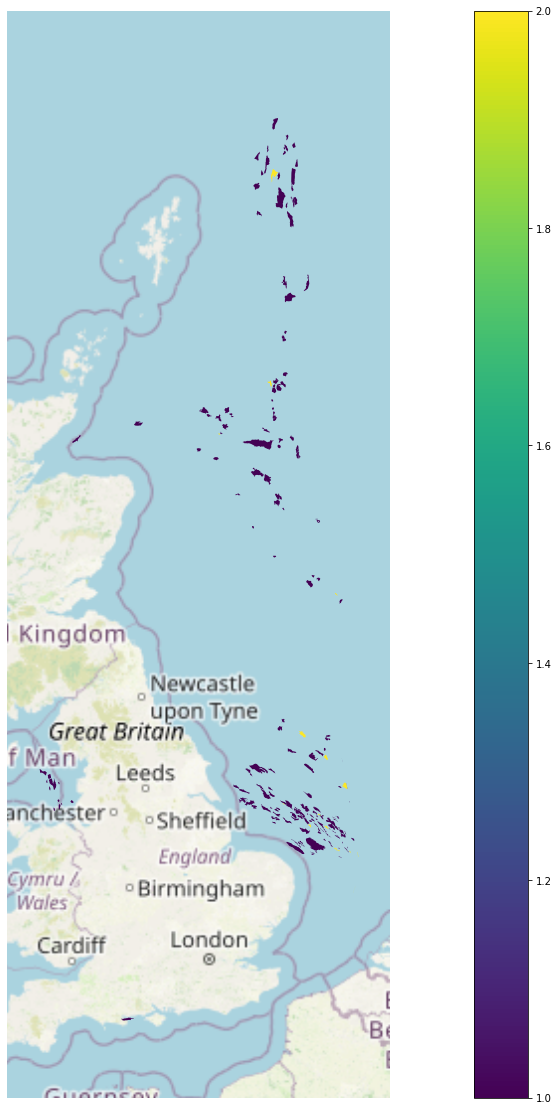

In [141]:
matching['color'] = matching.ASSESS_UNIT_TYPE.apply(lambda x: color_dict[x])
GB = gpd.clip(matching,mask=eu[eu.name == 'GB'])

background=gpd.read_file('../country_shapes.geojson')
ax = geoplot.webmap(background,projection=gcrs.WebMercator(),figsize=(30,20),alpha=1)

geoplot.choropleth(GB,hue='color',ax=ax,edgecolor='red', linewidth=0,legend=True)

In [13]:
#import pycountry
code = pycountry.countries.search_fuzzy('IT')[0].alpha_2
storage_unit[storage_unit['COUNTRYCODE']==code]

,OBJECTID,FORMATION_ID,STORAGE_UNIT_ID,STORAGE_UNIT_NAME,ASSESS_UNIT_TYPE,PERIOD_MIN,PERIOD_MAX,AGE_MIN,AGE_MAX,LITHOLOGY,...,COUNTRYCODE,LAMBERT_E,LAMBERT_N,X_DD,Y_DD,X,Y,Projection_Info,Date_Entered,geometry
75,174,IT_F_20121001124148805,IT_S_20121001151504215,Casirate 1 - Lombardia 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,pebblestone,...,IT,0.0,0.0,0.0,0.0,9.563056,45.489722,x: long - y: lat - WGS84,01-010-12 15:15:04,POINT (9.56306 45.48972)
76,175,IT_F_20121003174905644,IT_S_20121003175745519,Pandino 1 - Lombardia 2 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Piacenzian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,9.463889,45.413611,x: long - y: lat - WGS84,03-010-12 17:57:45,POINT (9.46389 45.41361)
77,176,IT_F_20121004153029368,IT_S_20121004153204821,Poggio Rusco 1 - Lombardia 3 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Aquitanian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,11.176389,44.947222,x: long - y: lat - WGS84,04-010-12 15:32:04,POINT (11.17639 44.94722)
78,177,IT_F_20121004163430395,IT_S_20121004175734558,S.Pietro in Casale 3 - Emilia 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,11.391944,44.716667,x: long - y: lat - WGS84,04-010-12 17:57:34,POINT (11.39194 44.71667)
79,178,IT_F_20121009153149008,IT_S_20121009153225384,Filetto1 - Emilia 2 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Gelasian,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,12.071389,44.322500,x: long - y: lat - WGS84,09-010-12 15:32:25,POINT (12.07139 44.32250)
80,179,IT_F_20121009161532346,IT_S_20121009161621580,BAGNOLO MELLA SU,Saline Aquifer with hydrocarbon fields,NaN,NaN,NaN,NaN,NaN,...,IT,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,09-010-12 16:16:21,POINT (0.00000 0.00000)
81,180,IT_F_20121010122552181,IT_S_20121010122618306,Serena Nord 1 - Emilia mare SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Zanclean,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,12.959167,44.110000,x: long - y: lat - WGS84,10-010-12 12:26:18,POINT (12.95917 44.11000)
82,181,IT_F_20121010135221305,IT_S_20121010135239899,Jesi 6 - Marche 1 SU,Saline Aquifer without hydrocarbon fields,NaN,NaN,NaN,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,13.260278,43.578611,x: long - y: lat - WGS84,10-010-12 13:52:39,POINT (13.26028 43.57861)
83,182,IT_F_20121010141900087,IT_S_20121010143318891,Notaresco 1 - Abruzzi 1 SU,Saline Aquifer without hydrocarbon fields,Neogene,NaN,Piacenzian,NaN,conglomerates,...,IT,0.0,0.0,0.0,0.0,13.956944,42.650833,x: long - y: lat - WGS84,10-010-12 14:33:18,POINT (13.95694 42.65083)
84,183,IT_F_20121010145802588,IT_S_20121010151127297,Pomarico 7 - Basilicata 1 SU,Saline Aquifer without hydrocarbon fields,quaternary,NaN,NaN,NaN,Sandstone,...,IT,0.0,0.0,0.0,0.0,16.489444,40.518889,x: long - y: lat - WGS84,10-010-12 15:11:27,POINT (16.48944 40.51889)
